In [3]:
from transformers import BertForMaskedLM, BertTokenizerFast
# Load the saved model and tokenizer
model = BertForMaskedLM.from_pretrained('../100m/lr-4e4_4-epoch_loss-3.1_model/')
tokenizer = BertTokenizerFast.from_pretrained('../coca_tokenized/tokenizer/')

In [145]:
import torch
import torch.nn.functional as F

def l(l_context, r_context, fill, model, tokenizer):
    model.eval()
    
    # Encode target span
    target_ids = tokenizer.encode(fill, add_special_tokens=False)
    num_masks = len(target_ids)
    
    # Encode context
    l_ids = tokenizer.encode(l_context, add_special_tokens=False)
    r_ids = tokenizer.encode(r_context, add_special_tokens=False)

    # Build input: [CLS] + left + [MASK x N] + right + [SEP]
    input_ids = tokenizer.build_inputs_with_special_tokens(
        l_ids + [tokenizer.mask_token_id] * num_masks + r_ids
    )
    input_ids = torch.tensor(input_ids).unsqueeze(0)  # [1, seq_len]
    
    mask_start = len(tokenizer.build_inputs_with_special_tokens(l_ids))  # index of first mask

    with torch.no_grad():
        outputs = model(input_ids=input_ids)
        logits = outputs.logits[0]  # [seq_len, vocab_size]

    log_likelihood = 0.0
    for i in range(num_masks):
        token_logits = logits[mask_start + i]
        log_probs = F.log_softmax(token_logits, dim=-1)
        log_likelihood += log_probs[target_ids[i]].item()

    return log_likelihood


In [118]:
from matplotlib import pyplot as plt
def tlplot(l_context, r_context, fill, annotate=None, annotate_text=None, values_only=False):
    ts = list(range(1990, 2019))
    ys = []
    for year in ts:
        cur_l_context = '[YEAR:{}] '.format(year) + l_context
        cur_l = l(cur_l_context, r_context, fill, model, tokenizer)
        ys.append(cur_l)

    # Calculate moving average with window size 5
    window_size = 5
    ys_smoothed = []
    for i in range(len(ys)):
        start_idx = max(0, i - window_size // 2)
        end_idx = min(len(ys), i + window_size // 2 + 1)
        window = ys[start_idx:end_idx]
        ys_smoothed.append(sum(window) / len(window))
    
    # Use smoothed values for plotting
    ys = ys_smoothed

    if values_only:
        return ys

    plt.figure()
    plt.title('logp({} | {lcontext} [MASK] {rcontext}; t)'.format(fill, lcontext=l_context, rcontext=r_context))
    plt.plot(ts, ys)
    plt.xlabel('t')

    if annotate != None:
        plt.axvspan(annotate[0], annotate[1], alpha=0.3, color='green')
        if annotate_text != None:
            plt.text(annotate[0], min(ys), annotate_text, ha='left', va='bottom')
    plt.show()

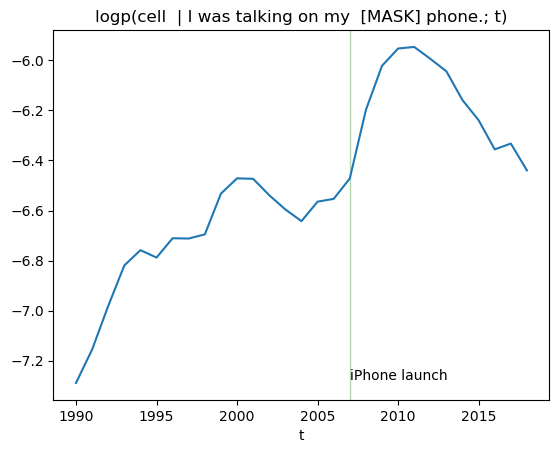

In [104]:
tlplot(l_context='I was talking on my ', fill='cell ', r_context='phone.', annotate=(2007, 2007), annotate_text='iPhone launch')

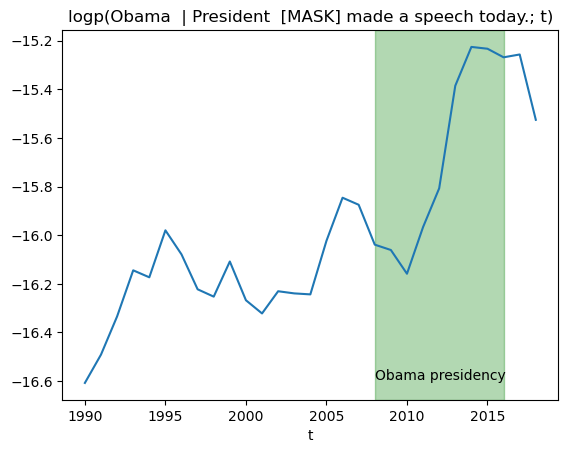

In [105]:
tlplot(l_context='President ', fill='Obama ', r_context='made a speech today.', annotate=(2008, 2016), annotate_text='Obama presidency')

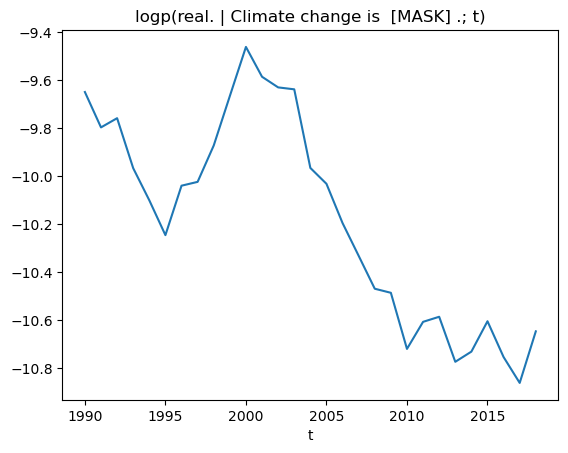

In [116]:
tlplot(l_context='Climate change is ', fill='real.', r_context='.')

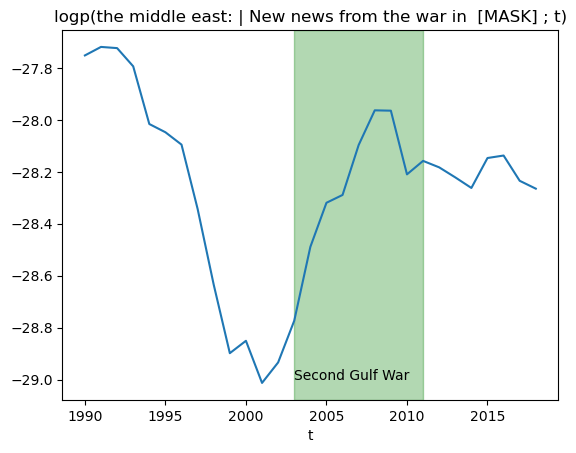

In [108]:
tlplot(l_context='New news from the war in ', fill='the middle east:', r_context='', annotate=(2003, 2011), annotate_text='Second Gulf War')

In [92]:
year_embeddings = []
ts = list(range(1990, 2019))
for t in ts:
    text = '[YEAR:{}]'.format(t)
    o = model(tokenizer.encode(text, add_special_tokens=False, return_tensors='pt'))
    year_embeddings.append(o)

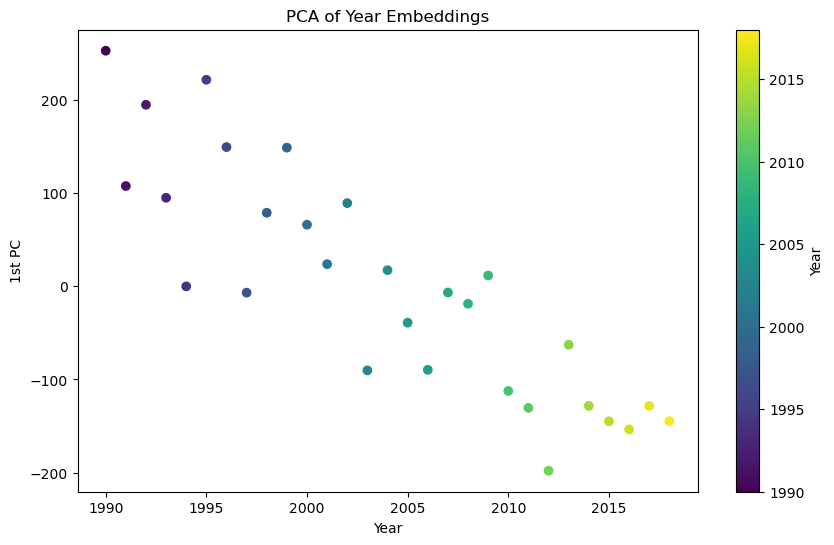

In [95]:
import numpy as np
# Convert to numpy array
year_matrix = np.stack([e[0].detach().numpy().reshape(-1,) for e in year_embeddings])

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
year_pca = pca.fit_transform(year_matrix)

# Plot the PCA results
plt.figure(figsize=(10, 6))
plt.scatter(ts, year_pca[:, 0], c=range(1990, 2019), cmap='viridis')
plt.colorbar(label='Year')
plt.xlabel('Year')
plt.ylabel('1st PC')
plt.title('PCA of Year Embeddings')
plt.show()

In [143]:
def multiplot(l_context, r_context, fills, tokenizer):

    for fill in fills:
        target_ids = tokenizer.encode(fill, add_special_tokens=False)
        num_masks = len(target_ids)
        print('{} masks for fill: {}'.format(num_masks, fill))


    plt.figure(figsize=(10, 6))
    plt.title('logp( $\\cdot$ | {lcontext} [MASK] {rcontext}; t)'.format(lcontext=l_context, rcontext=r_context))
    for fill in fills:
        ys = tlplot(l_context=l_context, fill=fill, r_context=r_context, values_only=True)
        plt.plot(ts, ys, label=fill)

    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Log Probability')
    plt.show()

1 masks for fill: pay
1 masks for fill: cell 


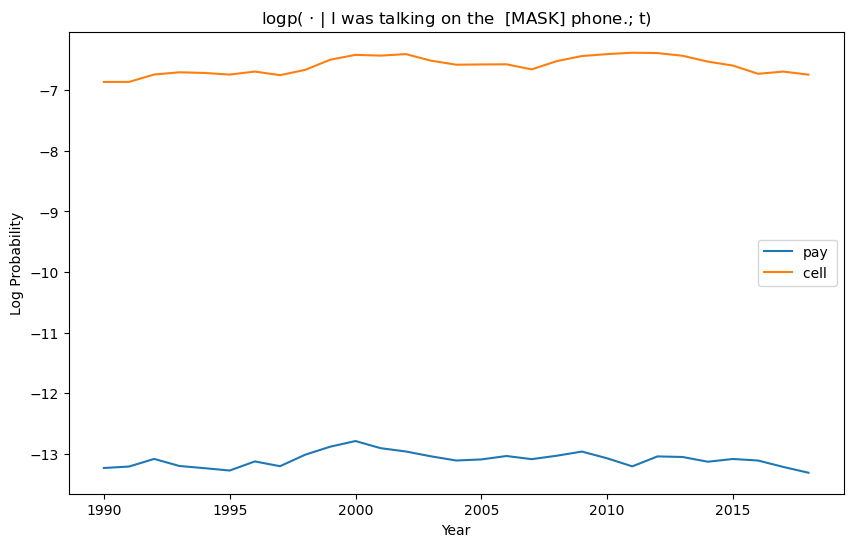

In [156]:
#multiplot(l_context='The United States should ', fills=['open ', 'close '], r_context=' its borders.', tokenizer=tokenizer)
#multiplot(l_context='President ', fills=['Obama ', 'Clinton ', 'Trump', 'Bush '], r_context=' made a speech today.', tokenizer=tokenizer)
multiplot(l_context='I was talking on the ', fills=['pay', 'cell '], r_context='phone.', tokenizer=tokenizer)